# Half Frequency Mask

In this notebook, we give a intuitive demonstration on why only the lower half
of the frequency components can be used for our wave function to guarantee an accurate
density function.

## Wave function

We consider a 1D system, similar to the 3D system, we can also define a cell vector constant,
here it is a scalar. 

In the real space, the size of our cell is `a=1`, we create a grid of `7` points within that cell.
Following the convention of FFT, we roll the negative part of the vector to the right hand side of the positive part.

[ 0.          0.14285715  0.2857143   0.42857146 -0.42857146 -0.2857143
 -0.14285715]


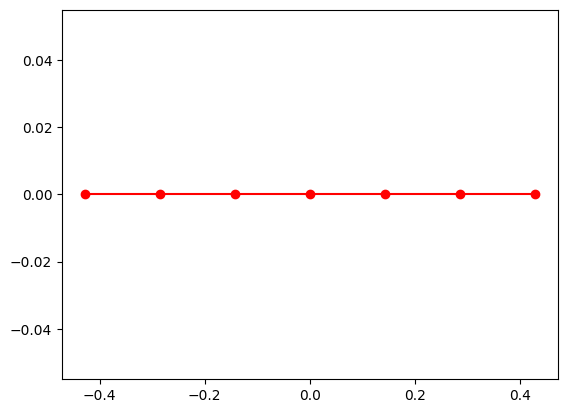

In [29]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot

key = jax.random.PRNGKey(0)

a = 1.
r = jnp.arange(-3, 4, 1) * a / 7
pyplot.plot(r, jnp.zeros_like(r), "r-o")

# Roll the negative part
r = jnp.concatenate([r[3:], r[:3]])
print(r)

Correspondingly, we can create a grid in the frequency space, the cell size is $b=2\pi/a$, and we call the grid `G`.

In [30]:
b = 2 * jnp.pi / a
G = jnp.arange(-3, 4, 1) * b
G = jnp.concatenate([G[3:], G[:3]])

Now, assume we have a wave function $\psi(r)$ in the real space, 
which is a linear combination of all the frequency compoents

$$
\psi(r) = \sum_i c_i e^{\mathrm{i}G_ir}
$$

In [31]:
c = jax.random.normal(key, (7,), dtype=jnp.complex64)

def psi(r):
  gr = G * r
  return jnp.tensordot(c, jnp.exp(1.j*gr), (-1, -1))

Then to evaluate $\psi$ on the `r` grid we defined above, there are two equivalent ways,
1. Directly evaluate the analytical function.
2. Via inverse discrete fourier transform.

We can verify that for whatever `c` we choose, the two results are equal up to a numerical error.

In [32]:
# 1. directly call the function
psi_r = jax.vmap(psi)(r)

# 2. via IFFT
psi_r_fft = jnp.fft.ifft(c) * 7

# Verify that they are the same up to numerical error
print(jnp.max(jnp.abs(psi_r - psi_r_fft)))

1.6942823e-06


Due to this property, the vector `c` is equivalent to evaluating the fourier transform of 
$\psi$ on the $G$ points. 

$$c=F(\psi)(G)$$

## Density function

Now let's consider the density function

$$
\rho(r) = \psi(r)^*\psi(r) = \sum_{i,j} c_ic_j e^{\mathrm{i}(G_i-G_j)r}
$$

We can see that the density function is made of frequency components computed from $G_i-G_j$, 
which can be as large as twice the largest element in $G$. 
Therefore, the density function has double the frequency components, 
if we still perform FFT on the original `G` grid we define above, it will be inaccurate.

In [33]:
def rho(r):
  return jnp.real(jnp.conj(psi(r)) * psi(r))

We also have two ways to compute the density function
1. Directly following the analytical formula.
2. Compute from the IFFT.

In [34]:
# 1. compute directly
rho_r = jax.vmap(rho)(r)

# 2. compute directly from IFFT
rho_r_fft = jnp.real(jnp.conj(psi_r_fft) * psi_r_fft)

Again these two computations match each other.

Although the FFT results correctly produces the density values at
the `r` grid, does these values `rho_r_fft` capture all the information of the function `rho`?
According the Nyquist sampling theorem, it has not.
It can be verified by constructing a new function that computes `rho`, that directly uses the 
frequency components captured by `rho_r_fft`.

$$
\rho(r) = \sum_i F(\rho)(G_i) e^{\mathrm{i}G_ir}
$$

In [35]:
# The linear weights of the frequency components
# captured by rho_r_fft
rho_G_fft = jnp.fft.fft(rho_r_fft) / 7

# we can recover the real space function that it represent
# by linear combination of the components
def rho_fft(r):
  gr = G * r
  return jnp.tensordot(rho_G_fft, jnp.exp(1.j*gr), (-1, -1)).real

We can verify whether the two computation methods aligns with each other.

Firstly, they will surely align on the `r` grid, 
because applying the `rho_fft` function on the `r` grid is exactly equivalent to performing IFFT on `rho_G_fft`, 
therefore `ifft(fft(rho_r_fft)) == rho_r_fft == rho_r`.

However, as we mentioned above, due to the sampling theorem, the number of points is too few to capture 
the analytical function $\rho(r) = \psi(r)^*\psi(r)$. This can be seen by plotting and comparing both functions in the 
real space cell.

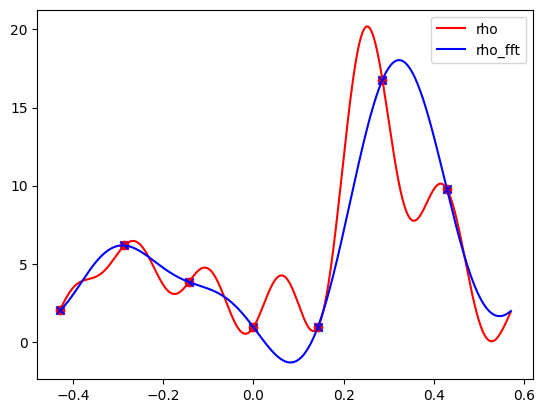

In [38]:
r_dense = jnp.arange(-3, 4, 0.01) * a / 7
pyplot.plot(r_dense, jax.vmap(rho)(r_dense), "r-", label="rho")
pyplot.scatter(r, jax.vmap(rho)(r), marker="o", color="r")
pyplot.plot(r_dense, jax.vmap(rho_fft)(r_dense), "b-", label="rho_fft")
pyplot.scatter(r, jax.vmap(rho_fft)(r), marker="x", color="b")
pyplot.legend()

Apparently, `rho_fft` loses lots of frequency components and tend to be smoother.

## Use only half frequency components

For remedy, in our program, we reduce the number of frequency components used by $\psi$.
Remember that the frequency components in $\rho$ are defined by $G_i-G_j$, 
therefore we keep a subset of frequencies $\tilde{G}$ such that 

$$\tilde{G}_i-\tilde{G}_j \in G;\;\forall{i, j}$$

Notice that we can easily swap $i, j$ to switch signs, therefore, we require 

$$|\tilde{G}_i-\tilde{G}_j| \leq \min(-\min(G), \max(G))$$

Let $U=\min(-\min(G), \max(G))$, 

- if $U$ is odd, we keep $\left[\lfloor -U/2 \rfloor \ldotp \ldotp \lfloor U/2 \rfloor\right]$
- if $U$ is even, we keep $\left[-U/2 \ldotp \ldotp U/2\right]$

With the above, we can now match the two functions.

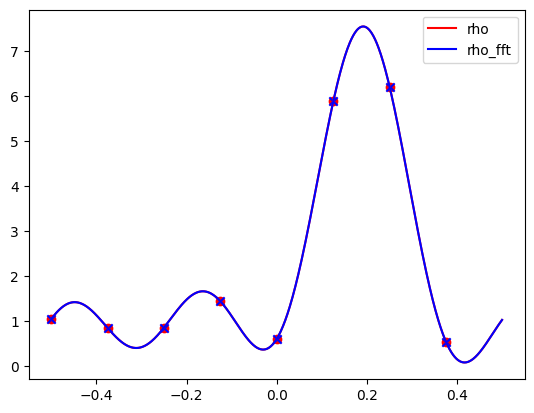

In [75]:
N = 8
a = 1.
r = jnp.arange(-(N//2), (N+1)//2, 1) * a / N
b = 2 * jnp.pi / a
G = jnp.arange(-(N//2), (N+1)//2, 1) * b
G = jnp.concatenate([G[N//2:], G[:N//2]])

# calculate the left and right cutoff points for
# the lower half of frequencies we would like to preserve.
min_G = -(N//2)
max_G = (N-1)//2
U = (N-1)//2
lbound = -U//2
rbound = U//2
assert rbound - lbound <= U

# set the other components to 0
c = jax.random.normal(key, (N,), dtype=jnp.complex64)
c_half = c.at[rbound+1:lbound].set(0)

def psi(r):
  gr = G * r
  return jnp.tensordot(c_half, jnp.exp(1.j*gr), (-1, -1))

psi_r_fft = jnp.fft.ifft(c_half) * N
rho_r_fft = jnp.real(jnp.conj(psi_r_fft) * psi_r_fft)
rho_G_fft = jnp.fft.fft(rho_r_fft) / N

def rho(r):
  return jnp.real(jnp.conj(psi(r)) * psi(r))

def rho_fft(r):
  gr = G * r
  return jnp.tensordot(rho_G_fft, jnp.exp(1.j*gr), (-1, -1)).real

r_dense = jnp.arange(-(N//2), (N+1)//2, 0.01) * a / N
pyplot.plot(r_dense, jax.vmap(rho)(r_dense), "r-", label="rho")
pyplot.scatter(r, jax.vmap(rho)(r), marker="o", color="r")
pyplot.plot(r_dense, jax.vmap(rho_fft)(r_dense), "b-", label="rho_fft")
pyplot.scatter(r, jax.vmap(rho_fft)(r), marker="x", color="b")
pyplot.legend()